In [20]:
import json
import random
from statistics import mean
import numpy as np
import sys
import os
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.compose import TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
import matplotlib.pyplot as plt
from itertools import accumulate
import pickle
from pathlib import Path
import datetime
from tqdm import tqdm
import torch
import glob

In [21]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim, bias=False)
        
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [22]:
#Load training sets and test set
X_train = None
y_train = None
X_test = None
y_test = None

xsets = glob.glob(r'data\*X.npy')

for xset in xsets:
    if X_test is None:
        print('Loading', xset, 'as test set')
        X_test = torch.Tensor(np.load(xset))
    else:
        print('Loading', xset, 'as training set')
        if X_train is None:
            X_train = torch.Tensor(np.load(xset))
        else:
            X_train = torch.cat((X_train, torch.Tensor(np.load(xset))))
 
ysets = glob.glob(r'data\*Y.npy')

for yset in ysets:
    if y_test is None:
        print('Loading', yset, 'as test set labels')
        y_test = torch.Tensor(np.load(yset))
    else:
        print('Loading', yset, 'as training set labels')
        if y_train is None:
            y_train = torch.Tensor(np.load(yset))
        else:
            y_train = torch.cat((y_train, torch.Tensor(np.load(yset))))

Loading data\LinearModelData2022-10-21-15-02-47X.npy as test set
Loading data\LinearModelData2022-10-21-15-19-52X.npy as training set
Loading data\LinearModelData2022-10-21-15-37-03X.npy as training set
Loading data\LinearModelData2022-10-21-15-54-22X.npy as training set
Loading data\LinearModelData2022-10-21-16-11-57X.npy as training set
Loading data\LinearModelData2022-10-21-16-29-35X.npy as training set
Loading data\LinearModelData2022-10-21-16-46-58X.npy as training set
Loading data\LinearModelData2022-10-21-17-04-04X.npy as training set
Loading data\LinearModelData2022-10-21-17-21-10X.npy as training set
Loading data\LinearModelData2022-10-21-17-38-17X.npy as training set
Loading data\LinearModelData2022-10-21-15-02-47Y.npy as test set labels
Loading data\LinearModelData2022-10-21-15-19-52Y.npy as training set labels
Loading data\LinearModelData2022-10-21-15-37-03Y.npy as training set labels
Loading data\LinearModelData2022-10-21-15-54-22Y.npy as training set labels
Loading data\L

In [23]:
#Set up the training 
input_dim = 36 # 36 input features
output_dim = 1 # One output (should match the win probability)
learning_rate = 0.01

model = LogisticRegression(input_dim,output_dim)

criterion = torch.nn.L1Loss()
# criterion = torch.nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

losses = []
scores_test = []
scores_train = []
Iterations = []
iter = 0

Training Epochs: 100%|██████████| 8000000/8000000 [1:19:33<00:00, 1676.05it/s, loss = 0.026990583166480064 trainscore=0.8850766588411065 testscore=0.8831492978420771]  


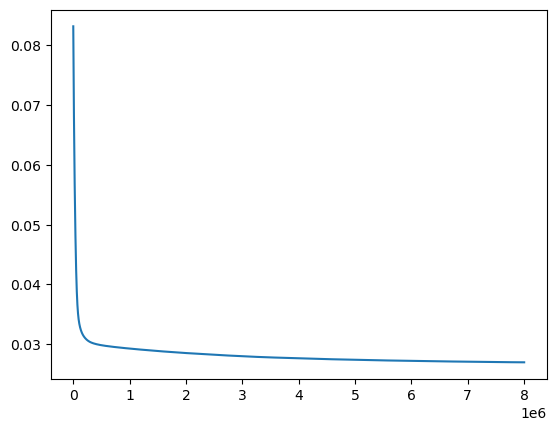

In [24]:
#Run this many epochs of training, starting wherever we stopped
epochs =  8_000_000
progress = tqdm(range(int(epochs)),desc='Training Epochs')
for epoch in progress:
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train)
    loss = criterion(torch.squeeze(outputs), labels) # [200,1] -squeeze-> [200]
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves 
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    

    iter+=1
    if iter%100==0:
        # calculate score for train and test sets
        train_score = r2_score(y_train,model(X_train).detach().numpy())
        test_score = r2_score(y_test,model(X_test).detach().numpy())
        scores_test.append(test_score)
        scores_train.append(train_score)

        with torch.no_grad():
            losses.append(loss.item())
            Iterations.append(iter)
            
            progress.set_postfix_str('loss = ' + str(loss.item()) + ' trainscore=' + str(train_score) + ' testscore=' + str(test_score))

plt.plot(Iterations, losses)
np.save('TrainingDataL1.npy', losses)

In [25]:
#Print out how many training iterations: 
print(f'Trained for {len(Iterations)} iterations')

Trained for 80000 iterations


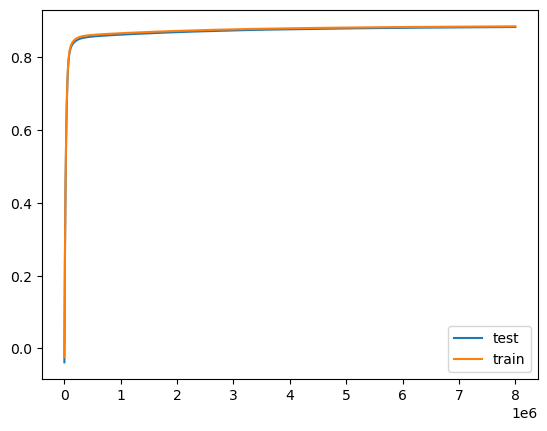

In [26]:
plt.plot(Iterations, scores_test, label='test')
plt.plot(Iterations, scores_train, label='train')
plt.legend()

Score of model: 0.8831492978420771


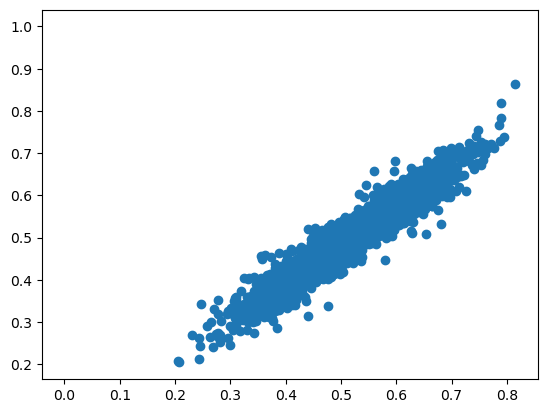

In [27]:
y_pred = model(X_test).detach().numpy()
print('Score of model:', r2_score(y_test, y_pred))
plt.scatter(y_test, y_pred)
plt.plot([0,0],[1,1], color='r')
plt.show()

In [28]:
#Save out the model to the dataobjects directory

filename = 'data' + os.path.sep + 'score_torch_colt_model.pt'
torch.save(model, filename)
print('Saved model to file: ', filename)

Saved model to file:  data\score_torch_model-Linear-Final-36-1-35v-2022-11-04-09-41-23.pt
